In [2]:
import os
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
from scipy.stats import ttest_ind
import seaborn as sns

# Consistency of cell type (gene- and isoform-based)

In [3]:
adata1 = ad.read_h5ad("results/scanpy_processed_gene_based.h5ad")
adata2 = ad.read_h5ad("results/scanpy_processed_transcript_based.h5ad")
print("Number of cells in gene-based h5ad:", len(adata1))
print("Number of cells in transcript-based h5ad:", len(adata2))

Number of cells in gene-based h5ad: 2535
Number of cells in transcript-based h5ad: 2529


In [4]:
s1 = adata1.obs["CellType"]
s2 = adata2.obs["CellType"]
s1.name = "CellType_GeneBased"
s2.name = "CellType_TranscriptBased"
d = pd.concat([s1, s2], axis=1, join="inner")
d.head()

,CellType_GeneBased,CellType_TranscriptBased
Cell,,
20220729_EmbryoR10.C01,TE-1,ICM-1
20220729_EmbryoR10.C02,TE-2,TE-1
20220729_EmbryoR10.C03,ICM-1,ICM-1
20220729_EmbryoR10.C04,ICM-1,ICM-1
20220729_EmbryoR10.C05,ICM-1,ICM-1


In [7]:
n1 = 0
n2 = 0
for ct1, ct2 in d[["CellType_GeneBased", "CellType_TranscriptBased"]].values:
    if ct1 == ct2:
        n1 += 1
        n2 += 1
    elif ct1.startswith("ICM-") and ct2.startswith("ICM-"):
        n2 += 1
print("Identical (strict): %d (%.2f%%)" % (n1, n1 * 100 / len(d)))
print("Identical (loose): %d (%.2f%%)" % (n2, n2 * 100 / len(d)))

Identical (strict): 2143 (84.74%)
Identical (loose): 2361 (93.36%)


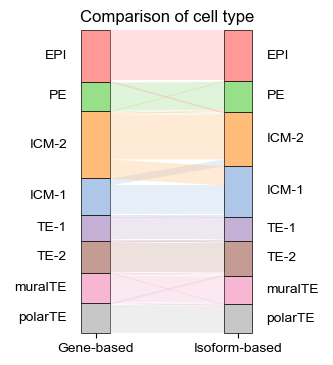

In [8]:
cts1 = ['polarTE', 'muralTE', 'TE-2', 'TE-1', 'ICM-1', 'ICM-2', 'PE', 'EPI']
cmap = plt.colormaps["tab20"]
colors1=[cmap(15), cmap(13), cmap(11), cmap(9), cmap(1), cmap(3), cmap(5), cmap(7)]

data = dict()
counter = Counter(d["CellType_GeneBased"])
bottom = 0
for k in cts1:
    v = counter[k]
    data[k] = dict()
    data[k]["Count"] = v
    data[k]["Bottom"] = bottom
    data[k]["Offset"] = 0
    bottom += v
data1 = data

cts2, colors2 = cts1, colors1
counter = Counter(d["CellType_TranscriptBased"])
data = dict()
bottom = 0
for k in cts2:
    v = counter[k]
    data[k] = dict()
    data[k]["Count"] = v
    data[k]["Bottom"] = bottom
    data[k]["Offset"] = 0
    bottom += v
data2 = data

data = defaultdict(list)
for ct1, ct2 in d[["CellType_GeneBased", "CellType_TranscriptBased"]].values:
    data[ct1].append(ct2)
    
plt.figure(figsize=(3.5, 3.75))
plt.title("Comparison of cell type")
w = 0.2
    
for i, k in enumerate(cts1):
    v = data1[k]
    x = 0
    b = v["Bottom"]
    h = v["Count"]
    plt.bar([x], h, bottom=b, width=w, lw=0.5, edgecolor="black", color=colors1[i], clip_on=False)
    plt.text(x - w/2 - 0.1, h / 2 + b, k, ha="right", va="center")
    
for i, k in enumerate(cts2):
    v = data2[k]
    x = 1
    b = v["Bottom"]
    h = v["Count"]
    plt.bar([x], h, bottom=b, width=w, lw=0.5, edgecolor="black", color=colors2[i], clip_on=False)
    plt.text(x + w/2 + 0.1, h / 2 + b, k, ha="left", va="center")
    
for i, k1 in enumerate(cts1):
    v1 = data[k1]
    counter = Counter(v1)
    ks = list(sorted(counter.keys(), key=lambda item: cts2.index(item)))
    for k2 in ks:
        h = counter[k2]

        y1 = data1[k1]["Bottom"] + data1[k1]["Offset"]
        y2 = y1 + h
        data1[k1]["Offset"] += h
        
        y3 = data2[k2]["Bottom"] + data2[k2]["Offset"]
        y4 = y3 + h
        data2[k2]["Offset"] += h
        
        # print(y1, y2, y3, y4)
        x1 = 0 + w / 2
        x2 = 1 - w / 2
        plt.fill_between([x1, x2], [y1, y3], [y2, y4], alpha=0.3, lw=0, color=colors1[i])
    
plt.xlim(0 - 0.6, 1 + 0.6)
plt.ylim(0, len(d))
plt.xticks([0, 1], ["Gene-based", "Isoform-based"])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/celltype_comparison.pdf", dpi=300)

In [9]:
cts = []
for ct1, ct2 in d[["CellType_GeneBased", "CellType_TranscriptBased"]].values:
    if ct1 == ct2:
        ct = ct1
    else:
        ct = np.nan
    cts.append(ct)
d["CellType"] = cts
d.to_csv("results/consensus_celltype.csv")

# Mismatch ratio and nascent RNA proportion

In [10]:
tmp = pd.read_csv("results/consensus_celltype.csv", index_col=0)
tmp = tmp[~tmp["CellType"].isna()]
d = pd.read_csv("../../1_FLAIRseq/reports/FLAIRseq_Summary.tsv", sep="\t")
d.index = d["Cell"]
d = d[d["UMIs"] >= 5000]
d = d[d.index.isin(tmp.index)]
d["CellType"] = tmp["CellType"]
print("Cells:", len(d))

Cells: 2143


In [11]:
cts = ['ICM-1', "ICM-2", "EPI", "PE", 'TE-1', 'TE-2', 'muralTE', 'polarTE']
ds = []
d1 = d[(d["s4U"] == 0) & (d["Time"] == 3) & (d["ActD"].isna())]
d2 = d[(d["s4U"] == 400) & (d["Time"] == 3) & (d["ActD"] == 0)]
d3 = d[(d["s4U"] == 400) & (d["Time"] == 3) & (d["ActD"] == 3)]
d4 = d[(d["s4U"] == 400) & (d["Time"] == 3) & (d["ActD"] == 6)]
ds.append(d1)
for ct in cts:
    d5 = d[(d["s4U"] == 400) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["CellType"] == ct)]
    ds.append(d5)
ds.append(d2)
ds.append(d3)
ds.append(d4)

0 1.0
1 4.4145960268250224e-32
2 2.4659764367418385e-75
3 1.546451914958682e-69
4 3.3756707581993822e-68
5 1.4788013622647744e-35
6 2.37692108914728e-47
7 8.546848228501956e-63
8 1.3265390450683283e-56
9 6.643916926557687e-61
10 0.00012137166848975926
11 0.037988544459505356


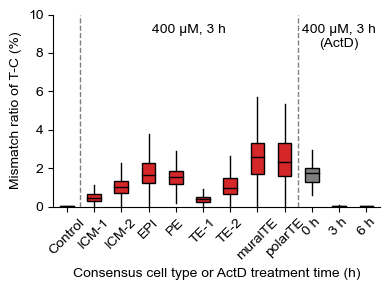

In [14]:
array = [tmp["TC.Ratio"].values * 100 for tmp in ds]
plt.figure(figsize=(4, 3))
ylim = 10
w = 0.5
xs = np.arange(len(array))
xticks = ["Control"] + cts + ["0 h", "3 h", "6 h"]
plt.boxplot(array[:1], positions=xs[:1], widths=w, showfliers=False, showcaps=False, 
            patch_artist=True, boxprops={"facecolor": "C7"}, 
            medianprops={"color": "black"})
plt.boxplot(array[1:-3], positions=xs[1:-3], widths=w, showfliers=False, showcaps=False, 
            patch_artist=True, boxprops={"facecolor": "C3"}, 
            medianprops={"color": "black"})
plt.boxplot(array[-3:], positions=xs[-3:], widths=w, showfliers=False, showcaps=False, 
            patch_artist=True, boxprops={"facecolor": "C7"}, 
            medianprops={"color": "black"})
plt.xticks(xs, xticks, rotation=45)
plt.axvline(0.5, lw=1, ls="--", color="grey")
plt.axvline(8.5, lw=1, ls="--", color="grey")
plt.text(4.5, ylim * 0.95, "400 μM, 3 h", ha="center", va="top")
plt.text(10, ylim * 0.95, "400 μM, 3 h\n(ActD)", ha="center", va="top")
for i in range(len(array)):
    vs1 = array[0]
    vs2 = array[i]
    p = ttest_ind(vs1, vs2)[1]
    print(i, p)
plt.xlabel("Consensus cell type or ActD treatment time (h)")
plt.ylim(0, ylim)
plt.ylabel("Mismatch ratio of T-C (%)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/mismatch_ratio_for_celltype.pdf")

0 1.0
1 8.403072064640598e-62
2 1.5086926519240077e-111
3 6.123657578271663e-112
4 2.5028320159330902e-88
5 4.722777397920574e-61
6 2.0639155799931956e-85
7 2.0654246646208867e-68
8 5.521458811805734e-57
9 5.243020010280608e-84
10 0.02942879805316542
11 0.02322616663270683


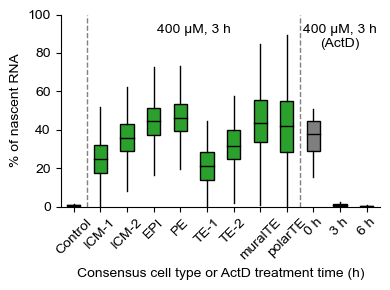

In [16]:
array = [tmp["UMIs.2Reads.Nascent.2TCs.Ratio"].values * 100 for tmp in ds]
plt.figure(figsize=(4, 3))
ylim = 100
w = 0.5
xs = np.arange(len(array))
xticks = ["Control"] + cts + ["0 h", "3 h", "6 h"]
plt.boxplot(array[:1], positions=xs[:1], widths=w, showfliers=False, showcaps=False, 
            patch_artist=True, boxprops={"facecolor": "C7"}, 
            medianprops={"color": "black"})
plt.boxplot(array[1:-3], positions=xs[1:-3], widths=w, showfliers=False, showcaps=False, 
            patch_artist=True, boxprops={"facecolor": "C2"}, 
            medianprops={"color": "black"})
plt.boxplot(array[-3:], positions=xs[-3:], widths=w, showfliers=False, showcaps=False, 
            patch_artist=True, boxprops={"facecolor": "C7"}, 
            medianprops={"color": "black"})
plt.xticks(xs, xticks, rotation=45)
plt.axvline(0.5, lw=1, ls="--", color="grey")
plt.axvline(8.5, lw=1, ls="--", color="grey")
plt.text(4.5, ylim * 0.95, "400 μM, 3 h", ha="center", va="top")
plt.text(10, ylim * 0.95, "400 μM, 3 h\n(ActD)", ha="center", va="top")
for i in range(len(array)):
    vs1 = array[0]
    vs2 = array[i]
    p = ttest_ind(vs1, vs2)[1]
    print(i, p)
plt.xlabel("Consensus cell type or ActD treatment time (h)")
plt.ylim(0, ylim)
plt.ylabel("% of nascent RNA")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/nascent_umi_ratio_for_celltype.pdf")

# Half-life (pseudo-bulk)

In [17]:
d = pd.read_csv("../../1_FLAIRseq/reports/FLAIRseq_Summary.tsv", sep="\t")
d.index = d["Cell"]
anno_ct = pd.read_csv("results/consensus_celltype.csv", index_col=0)
d = d.merge(anno_ct, left_index=True, right_index=True, how="inner")
d = d[~d["CellType"].isna()]
array = []
for ct, tmp in d.groupby(by="CellType"):
    tmp = tmp[(tmp["s4U"] == 400) & (tmp["Time"] == 3) & (tmp["ActD"].isna()) & (tmp["TC.Ratio"] >= 0.002)]
    print(ct, len(tmp), sep="\t")
    array.append([ct, tmp])

EPI	302
ICM-1	195
ICM-2	339
PE	180
TE-1	150
TE-2	219
muralTE	137
polarTE	151


In [18]:
anno_g = pd.read_csv("../../1_FLAIRseq/results/assembly_custom/gtf_full/MouseBlastocyst.gtf.gene_info.tsv", sep="\t", index_col=0)
anno_t = pd.read_csv("../../1_FLAIRseq/results/assembly_custom/gtf_full/MouseBlastocyst.gtf.transcript_info.tsv", sep="\t", index_col=0)

In [19]:
def get_halflife(total, nascent):
    if total == 0:
        return np.nan
    elif nascent == 0:
        return np.inf
    elif nascent == total:
        return 0
    else:
        ntr = nascent / total
        return -3 / np.log2(1 - ntr)

## 1. Celltype-specific expression (gene-based)

In [22]:
for ct, tmp in array:
    path1 = "results/halflife/%s.gene_based.filelist.txt" % ct
    path2 = "results/halflife/%s.gene_based.gene_id.tsv" % ct
    path3 = "results/halflife/%s.gene_based.gene_id.annotated.tsv" % ct
    print(ct, len(tmp), sep="\t")

    if not os.path.exists(path1):
        with open(path1, "w+") as fw:
            for run, cell in tmp[["Run", "Cell"]].values:
                path = "../../1_FLAIRseq/results/expression/quant_genes/min_read_2_min_tc_2/%s/%s.tsv" % (run, cell)
                fw.write(path + "\n")
                
    if not os.path.exists(path2):
        ! ../../1_FLAIRseq/scripts/merge_counts.py {path1} {path2}

    if not os.path.exists(path3):
        m = pd.read_csv(path2, sep="\t", index_col=0)
        m["TPM"] = m["Total"] * 1e6 / m["Total"].sum()
        m["TP10K"] = m["Total"] * 1e4 / m["Total"].sum()
        m["NTR"] = m["Nascent"] / m["Total"]
        m["T"] = [get_halflife(c1, c2) for c1, c2 in m[["Total", "Nascent"]].values]
        m["K"] = m["TP10K"] * np.log(2) / m["T"]
        m["D"] = np.log(2) / m["T"]
        m = m.merge(anno_g, left_index=True, right_index=True, how="left")
        m.to_csv(path3, sep="\t")

EPI	302
ICM-1	195
ICM-2	339
PE	180
TE-1	150
TE-2	219
muralTE	137
polarTE	151


## 2. Celltype-specific expression (isoform-based)

In [23]:
for ct, tmp in array:
    path1 = "results/halflife/%s.transcript_based.filelist.txt" % ct
    path2 = "results/halflife/%s.transcript_based.transcript_id.tsv" % ct
    path3 = "results/halflife/%s.transcript_based.transcript_id.annotated.tsv" % ct
    print(ct, len(tmp), sep="\t")

    if not os.path.exists(path1):
        with open(path1, "w+") as fw:
            for run, cell in tmp[["Run", "Cell"]].values:
                path = "../../1_FLAIRseq/results/expression_novel/quant_isoforms/min_read_2_min_tc_2/%s/%s.tsv" % (run, cell)
                fw.write(path + "\n")
                
    if not os.path.exists(path2):
        ! ../../1_FLAIRseq/scripts/merge_counts.py {path1} {path2}

    if not os.path.exists(path3):
        m = pd.read_csv(path2, sep="\t", index_col=0)
        m["TPM"] = m["Total"] * 1e6 / m["Total"].sum()
        m["TP10K"] = m["Total"] * 1e4 / m["Total"].sum()
        m["NTR"] = m["Nascent"] / m["Total"]
        m["T"] = [get_halflife(c1, c2) for c1, c2 in m[["Total", "Nascent"]].values]
        m["K"] = m["TP10K"] * np.log(2) / m["T"]
        m["D"] = np.log(2) / m["T"]
        m = m.merge(anno_t, left_index=True, right_index=True, how="left")
        m.to_csv(path3, sep="\t")

EPI	302
ICM-1	195
ICM-2	339
PE	180
TE-1	150
TE-2	219
muralTE	137
polarTE	151


# Correlation of cell type expression

Min value: 0.7205104876309095
Min value: 0.8004070745615819


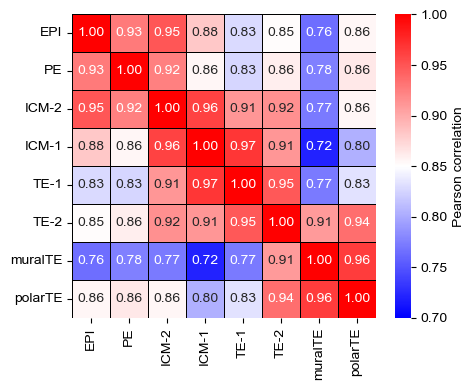

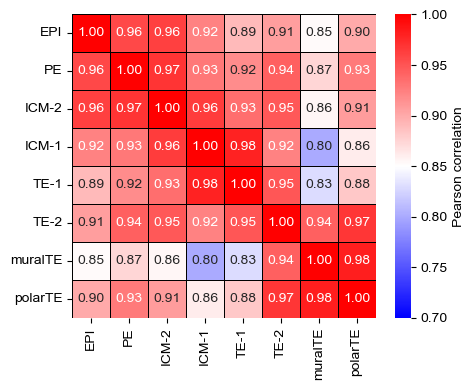

In [26]:
celltypes = ["EPI", "PE", "ICM-2", "ICM-1", "TE-1", "TE-2", "muralTE", "polarTE"]
for name in ["gene", "transcript"]:
    array = []
    for ct in celltypes:
        m = pd.read_csv("results/halflife/%s.%s_based.%s_id.annotated.tsv" % (ct, name, name), sep="\t", index_col=0)
        s = m["TPM"]
        s.name = ct
        array.append(s)
    d = pd.concat(array, axis=1).fillna(0)
    d.to_csv("results/expression/%s_based.%s_id.tsv" % (name, name), sep="\t")
    
    corr = d[d.max(axis=1) >= 100].corr(method="pearson")
    print("Min value:", corr.min().min())
    plt.figure(figsize=(5, 4))
    sns.heatmap(corr, cmap="bwr", vmin=0.7, vmax=1, 
                square=True, annot=True, fmt=".2f",
                lw=0.5, linecolor="black",
                cbar_kws=dict(label="Pearson correlation"))
    plt.tight_layout()
    plt.savefig("figures/celltype_expression_correlation.%s_based.pdf" % name)

/home/chenzonggui/miniconda3/envs/py3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chenzonggui/miniconda3/envs/py3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chenzonggui/miniconda3/envs/py3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chenzonggui/miniconda3/envs/py3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chenzonggui/miniconda3/envs/py3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwa

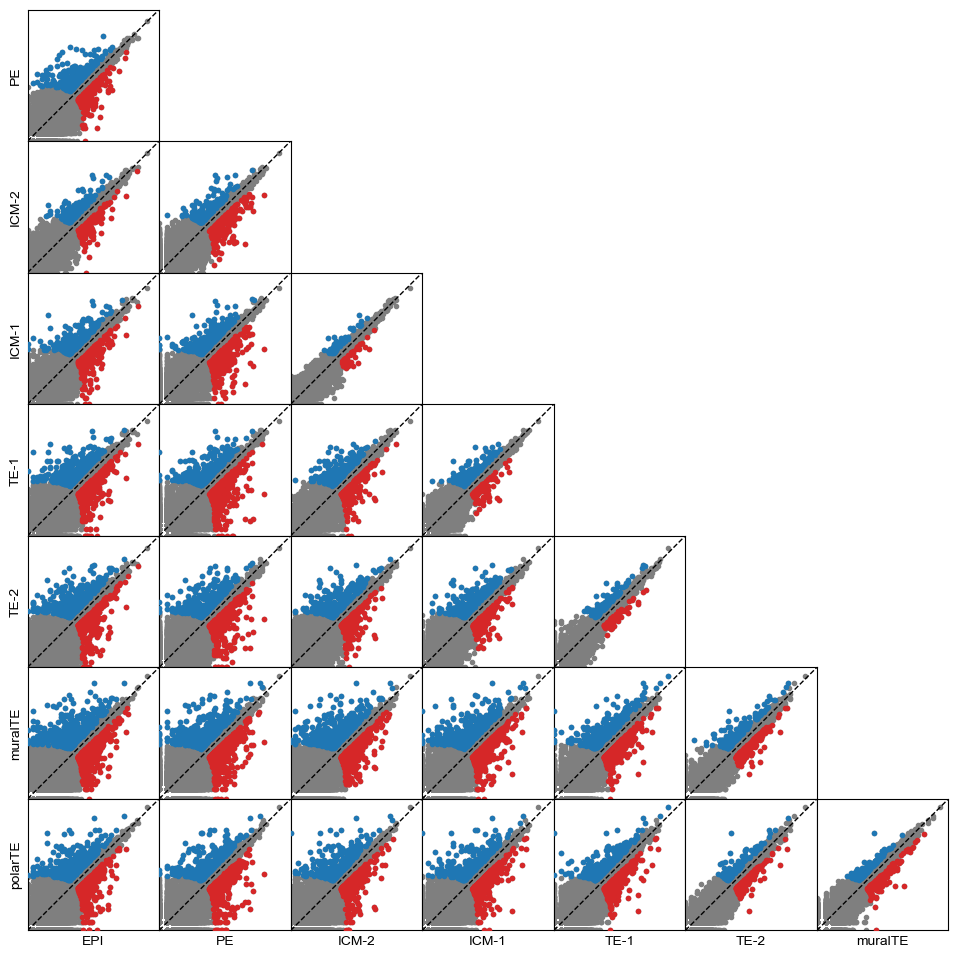

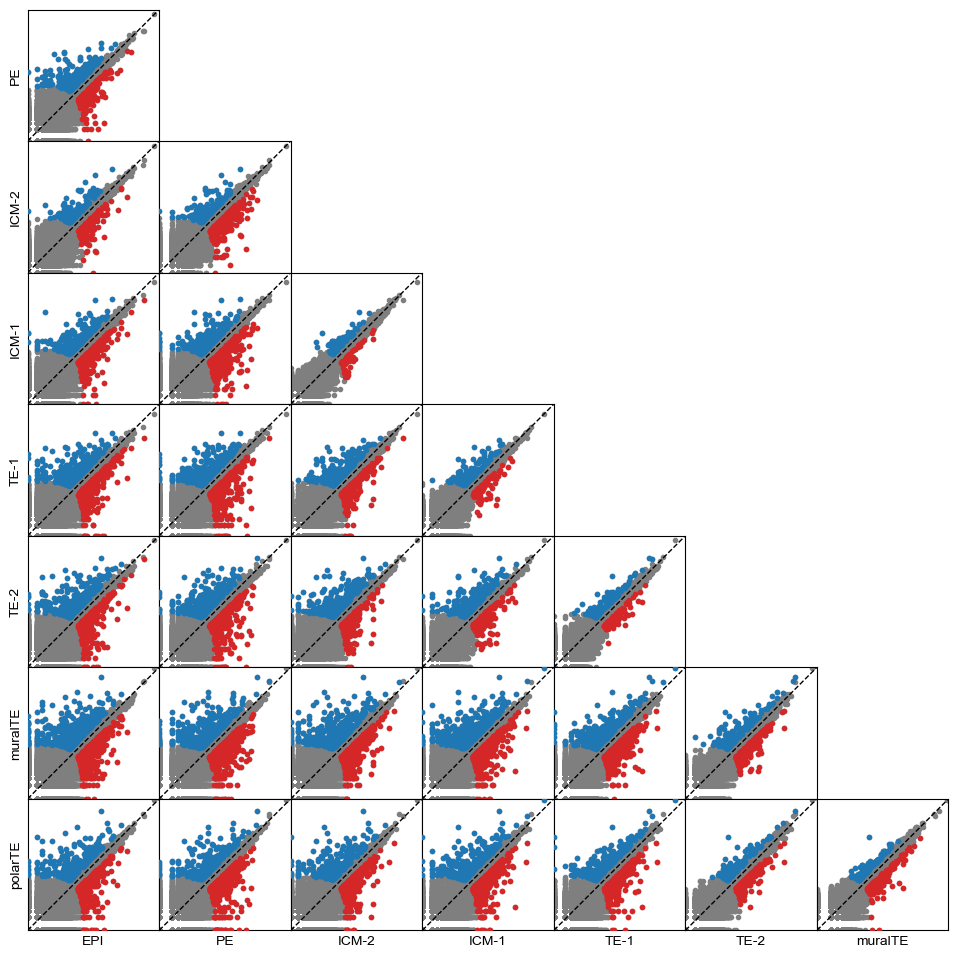

In [28]:
for name in ["gene", "transcript"]:
    d = pd.read_csv("results/expression/%s_based.%s_id.tsv" % (name, name), sep="\t", index_col=0)
    n = len(celltypes)
    lim = 16
    fig, axs = plt.subplots(n, n, figsize=(11, 11), sharex=True, sharey=True, gridspec_kw={"hspace": 0, "wspace": 0})
    for i in range(n):
        for j in range(n):
            ax = axs[i][j]
            plt.sca(ax)
            ct1, ct2 = celltypes[j], celltypes[i]
            if i == n - 1:
                plt.xlabel(ct1)
            if j == 0:
                plt.ylabel(ct2)
            if i > j:
                d1 = d[[ct1, ct2]].copy()
                d1["TPM.Min"] = d1[[ct1, ct2]].min(axis=1)
                d1["TPM.Max"] = d1[[ct1, ct2]].max(axis=1)
                d1["TPM.Mean"] = d1[[ct1, ct2]].mean(axis=1)
                d1["Log2FC"] = np.log2(np.divide(d1[ct2], d1[ct1]))
                xs1, ys1 = d1[ct1], d1[ct2]
                xs1, ys1 = np.log2(xs1 + 1), np.log2(ys1 + 1)
                cutoff = np.log2(2)
                d2 = d1[(d1["TPM.Mean"] >= 50) & (d1["Log2FC"] > cutoff)]
                d3 = d1[(d1["TPM.Mean"] >= 50) & (d1["Log2FC"] < -cutoff)]
                xs2, ys2 = d2[ct1], d2[ct2]
                xs3, ys3 = d3[ct1], d3[ct2]
                xs2, ys2 = np.log2(xs2 + 1), np.log2(ys2 + 1)
                xs3, ys3 = np.log2(xs3 + 1), np.log2(ys3 + 1)
                plt.scatter(xs1, ys1, marker=".", color="C7")
                plt.scatter(xs2, ys2, marker=".", color="C0", zorder=10)
                plt.scatter(xs3, ys3, marker=".", color="C3", zorder=10)
                plt.xlim(0, lim)
                plt.ylim(0, lim)
                plt.plot([0, lim], [0, lim], lw=1, ls="--", color="black")
                plt.xticks([])
                plt.yticks([])
            else:
                ax.set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/celltype_expression_correlation_scatter.%s_based.pdf" % name)

# BAM of cell type

In [3]:
d = pd.read_csv("results/consensus_celltype.csv")
d = d[~d["CellType"].isna()]
cts = list(sorted(set(d["CellType"])))
print(cts)

['EPI', 'ICM-1', 'ICM-2', 'PE', 'TE-1', 'TE-2', 'muralTE', 'polarTE']


In [4]:
def merge_cell_bams(cells, outfile):
    fw = None
    for cell in cells:
        path = "../../1_FLAIRseq/results/mapping/remove_duplicate/%s/%s.bam" % (cell.split(".")[0], cell)
        import pysam
        with pysam.AlignmentFile(path) as f:
            if fw is None:
                fw = pysam.AlignmentFile(outfile, "wb", f)
            for s in f:
                if s.is_duplicate:
                    continue
                else:
                    fw.write(s)
    if fw:
        fw.close()

def sort_bam(infile, outfile):
    cmd = "samtools sort -@ 4 -o %s %s" % (outfile, infile)
    print(cmd)
    subprocess.check_call(cmd, shell=True)
    cmd = "samtools index -@ 4 %s" % outfile
    print(cmd)
    subprocess.check_call(cmd, shell=True)

def bam_to_bigwig(bamfile, bwfile):
    cmd = "bam2bw_split.sh %s %s" % (bamfile, bwfile)
    print(cmd)
    subprocess.check_call(cmd, shell=True)

def bam_flagstat(bamfile, outfile):
    cmd = "samtools flagstat %s > %s" % (bamfile, outfile)
    print(cmd)
    subprocess.check_call(cmd, shell=True)

for ct in cts:
    print(ct)
    cells = d[d["CellType"] == ct]["Cell"]
    path1 = "results/cell_type_specific_bams/%s.unsorted.bam" % ct
    path2 = "results/cell_type_specific_bams/%s.bam" % ct
    path3 = "results/cell_type_specific_bams/%s.bw" % ct
    path4 = "results/cell_type_specific_bams/%s.flagstat" % ct
    if not os.path.exists(path1):
        merge_cell_bams(cells, path1)
    if not os.path.exists(path2):
        sort_bam(path1, path2)
    if not os.path.exists(path3):
        bam_to_bigwig(path2, path3)
    if not os.path.exists(path4):
        bam_flagstat(path2, path4)

EPI
ICM-1
ICM-2
PE
TE-1
TE-2
muralTE
polarTE
